# Log-Gaussian Cox Process Regression via Kalman Smoothing

## Import and load data

loading coal data ...


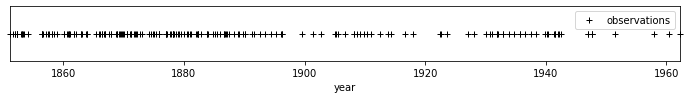

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import time
import pandas as pd
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot

plot_intermediate = False

print('loading coal data ...')
disaster_timings = pd.read_csv('../../data/coal.txt', header=None).values[:, 0]

# Discretization
num_time_bins = 200
# Discretize the data
x = np.linspace(min(disaster_timings), max(disaster_timings), num_time_bins).T
y = np.histogram(disaster_timings, np.concatenate([[-1e10], x[:-1] + np.diff(x)/2, [1e10]]))[0][:, None]
# Test points
x_test = x

# meanval = np.log(len(disaster_timings)/num_time_bins)  # TODO: incorporate mean

plt.figure(1, figsize=(12, 1))
plt.plot(disaster_timings, 0*disaster_timings, 'k+', label='observations', clip_on=False)
plt.xlim(x_test[0], x_test[-1])
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
plt.xlabel('year')
plt.legend();

## Build the GP model

In [2]:
var_f = 1.0  # GP variance
len_f = 1.0  # GP lengthscale

prior = priors.Matern52(variance=var_f, lengthscale=len_f)
lik = likelihoods.Poisson()
# inf_method = approx_inf.EP(power=0.5)
# inf_method = approx_inf.SLEP()
inf_method = approx_inf.EKS()
# inf_method = approx_inf.EEP()
# inf_method = approx_inf.VI()

model = SDEGP(prior=prior, likelihood=lik, t=x, y=y, approx_inf=inf_method)

/Users/wilkinw1/Library/Python/3.7/lib/python/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


building SDE-GP with Matern-5/2 prior and Poisson likelihood ...
inference method is Extended Kalman Smoother (EKS)


## Set up the optimiser

In [3]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-1)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 10) == 0:
        print('iter %2d: var_f=%1.2f len_f=%1.2f, nlml=%2.2f' %
            (i, prior_params[0], prior_params[1], neg_log_marg_lik))

    if plot_intermediate:
        plot(mod, i)

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [4]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var_f=1.00 len_f=1.00, nlml=295.62
iter 10: var_f=0.33 len_f=4.69, nlml=276.66
iter 20: var_f=0.36 len_f=7.68, nlml=273.62
iter 30: var_f=0.36 len_f=9.76, nlml=272.45
iter 40: var_f=0.37 len_f=11.16, nlml=272.04
iter 50: var_f=0.39 len_f=12.13, nlml=271.84
iter 60: var_f=0.38 len_f=12.85, nlml=271.73
iter 70: var_f=0.40 len_f=13.40, nlml=271.67
iter 80: var_f=0.39 len_f=13.86, nlml=271.62
iter 90: var_f=0.40 len_f=14.25, nlml=271.60
iter 100: var_f=0.40 len_f=14.59, nlml=271.58
iter 110: var_f=0.41 len_f=14.89, nlml=271.56
iter 120: var_f=0.41 len_f=15.16, nlml=271.55
iter 130: var_f=0.41 len_f=15.41, nlml=271.54
iter 140: var_f=0.41 len_f=15.62, nlml=271.54
iter 150: var_f=0.42 len_f=15.82, nlml=271.53
iter 160: var_f=0.42 len_f=16.00, nlml=271.53
iter 170: var_f=0.42 len_f=16.16, nlml=271.53
iter 180: var_f=0.42 len_f=16.30, nlml=271.53
iter 190: var_f=0.42 len_f=16.43, nlml=271.53
optimisation time: 14.93 secs


## Make predictions

In [5]:
x_plot = np.linspace(np.min(x_test)-5, np.max(x_test)+5, 200)
print('calculating the posterior predictive distribution ...')
t0 = time.time()
posterior_mean, posterior_cov = model.predict(t=x_plot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

calculating the posterior predictive distribution ...
prediction time: 1.63 secs


## Sample from the posterior distribution

In [6]:
print('sampling from the posterior ...')
t0 = time.time()
posterior_samp = model.posterior_sample(20, t=x_plot)
t1 = time.time()
print('sampling time: %2.2f secs' % (t1-t0))

sampling from the posterior ...
sampling time: 4.37 secs


## Plot the posterior

plotting ...


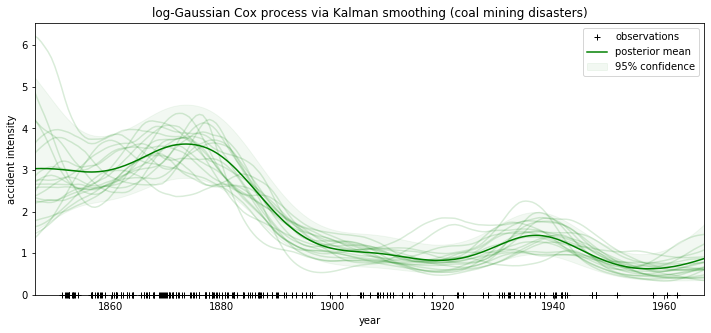

In [7]:
link_fn = model.likelihood.link_fn
scale = num_time_bins / (max(x) - min(x))
post_mean_lgcp = link_fn(posterior_mean + posterior_cov / 2) * scale
lb_lgcp = link_fn(posterior_mean - np.sqrt(posterior_cov) * 1.645) * scale
ub_lgcp = link_fn(posterior_mean + np.sqrt(posterior_cov) * 1.645) * scale
post_samp_lgcp = link_fn(posterior_samp) * scale

print('plotting ...')
plt.figure(2, figsize=(12, 5))
plt.clf()
plt.plot(disaster_timings, 0*disaster_timings, 'k+', label='observations', clip_on=False)
plt.plot(x_plot, post_mean_lgcp, 'g', label='posterior mean')
plt.fill_between(x_plot, lb_lgcp, ub_lgcp, color='g', alpha=0.05, label='95% confidence')
plt.plot(x_plot, post_samp_lgcp, 'g', alpha=0.15)
plt.xlim(x_plot[0], x_plot[-1])
plt.ylim(0.0)
plt.legend()
plt.title('log-Gaussian Cox process via Kalman smoothing (coal mining disasters)')
plt.xlabel('year')
plt.ylabel('accident intensity');